In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import gnuradio.digital
import struct
import pathlib
plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
files = sorted(list(pathlib.Path('lev1-camras-decodes').glob('*.u8')))
names = [f.name for f in files]
data = [np.unpackbits(np.fromfile(f, 'uint8')) for f in files]

In [3]:
syncword_hex = 'FAF320'
syncword = 2*np.unpackbits(np.frombuffer(bytes.fromhex(syncword_hex), dtype = 'uint8')).astype('int')-1
syncword_corrs = [np.correlate(2*d.astype('int')-1, syncword)/syncword.size for d in data]

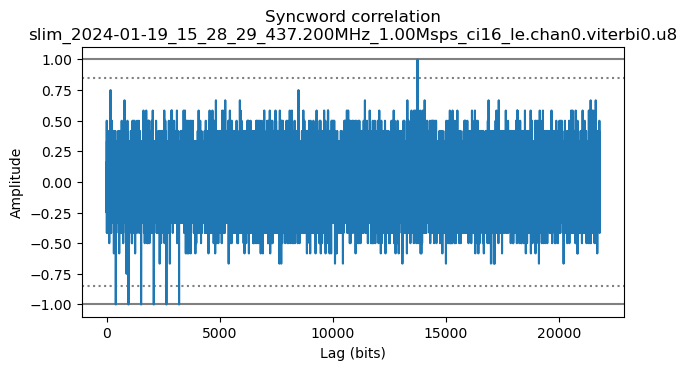

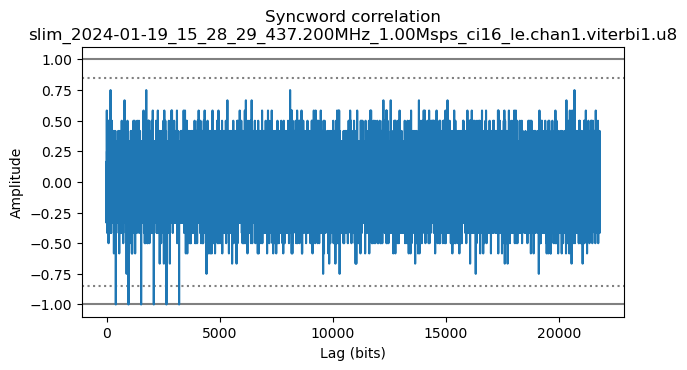

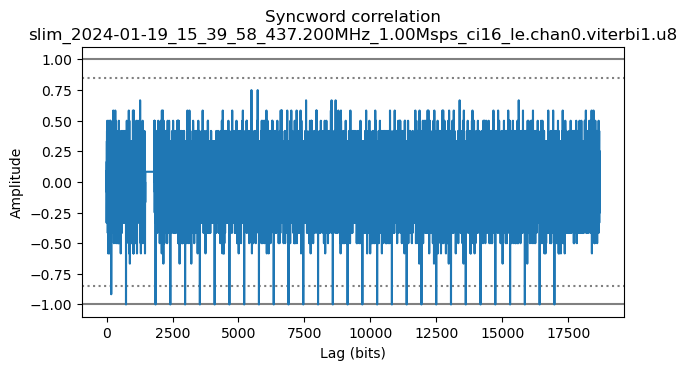

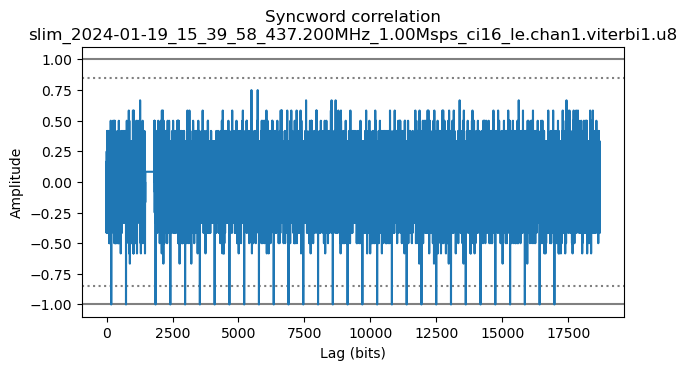

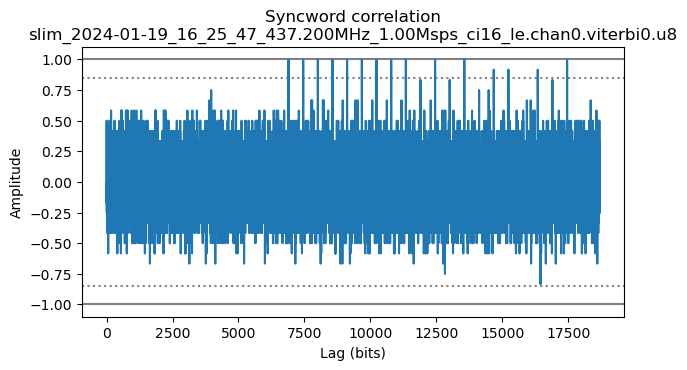

In [4]:
threshold = 0.85
for name, sc in zip(names, syncword_corrs):
    plt.figure()
    for s in [1, -1]:
        plt.axhline(y=s, color='grey')
        plt.axhline(y=threshold*s, linestyle=':', color='grey')
    plt.plot(sc)
    plt.title(f'Syncword correlation\n{name}')
    plt.xlabel('Lag (bits)')
    plt.ylabel('Amplitude');

In [5]:
L = 520
frames = []

crc_calc = gnuradio.digital.crc(16, 0x1021, 0xFFFF, 0x0, False, False)
def check_crc(frame):
    return crc_calc.compute(frame[3:-2]) == struct.unpack('>H', bytes(frame[-2:]))[0]

for d, sc in zip(data, syncword_corrs):
    locs = np.where(np.abs(sc) >= threshold)[0]
    signs = sc[locs] < 0    
    frames.append(np.array([frame[:-2]
                            for s, loc in zip(signs, locs)
                            if check_crc((frame := np.packbits(d[loc+syncword.size:][:L] ^ s)))]))

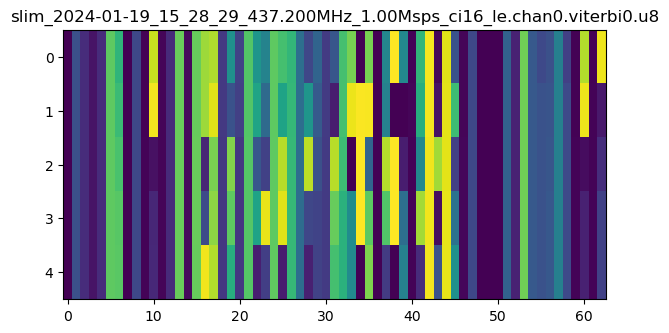

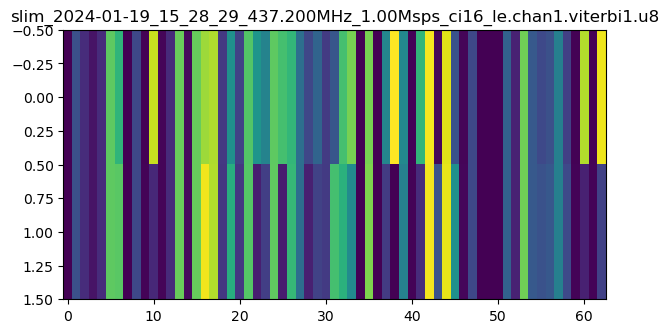

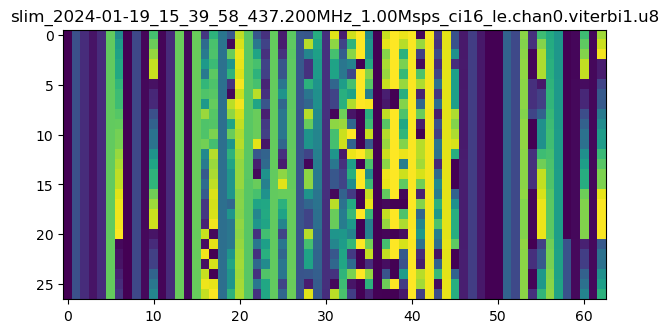

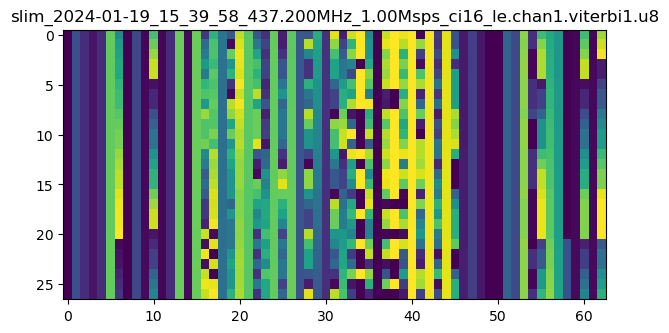

In [6]:
for name, fr in zip(names, frames):
    if fr.size == 0:
        continue
    plt.figure()
    plt.imshow(fr, aspect='auto', interpolation='none')
    plt.title(name)

In [7]:
timestamps = frames[-2][:, 7:11].view('uint32').byteswap().ravel()
timestamps[-1] - timestamps[0]

449

In [8]:
np.datetime64('2024-01-19T15:39:58') - timestamps * np.timedelta64(1, 's')

array(['2023-12-08T22:05:14', '2023-12-08T22:04:56',
       '2023-12-08T22:04:39', '2023-12-08T22:04:21',
       '2023-12-08T22:04:20', '2023-12-08T22:03:47',
       '2023-12-08T22:03:30', '2023-12-08T22:03:29',
       '2023-12-08T22:02:56', '2023-12-08T22:02:38',
       '2023-12-08T22:02:21', '2023-12-08T22:02:20',
       '2023-12-08T22:01:47', '2023-12-08T22:01:29',
       '2023-12-08T22:01:12', '2023-12-08T22:01:11',
       '2023-12-08T22:00:38', '2023-12-08T22:00:20',
       '2023-12-08T22:00:03', '2023-12-08T22:00:02',
       '2023-12-08T21:59:29', '2023-12-08T21:59:11',
       '2023-12-08T21:58:54', '2023-12-08T21:58:53',
       '2023-12-08T21:58:20', '2023-12-08T21:58:02',
       '2023-12-08T21:57:45'], dtype='datetime64[s]')

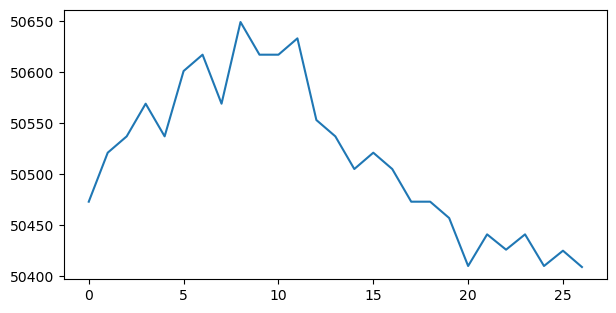

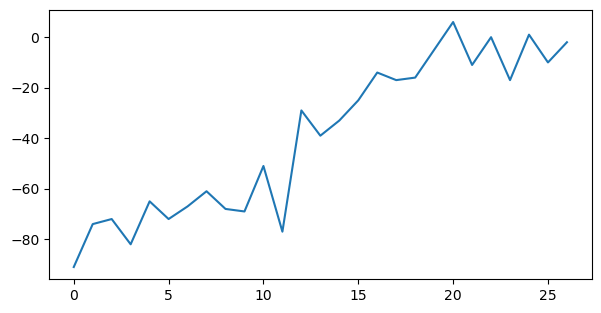

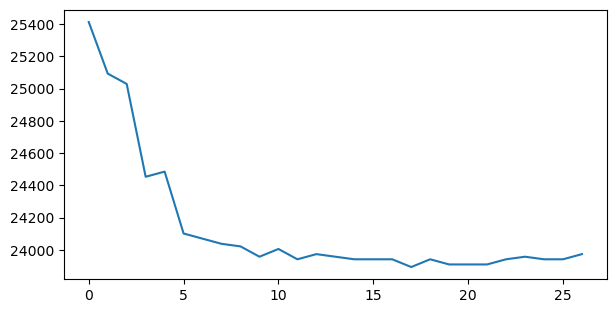

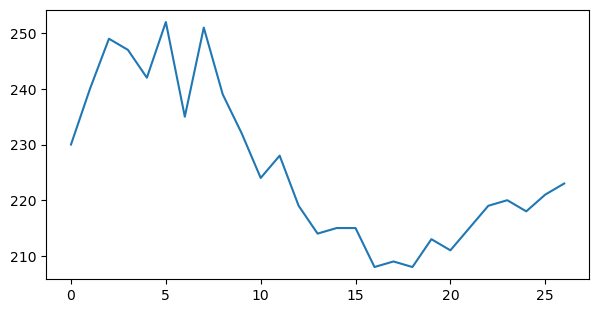

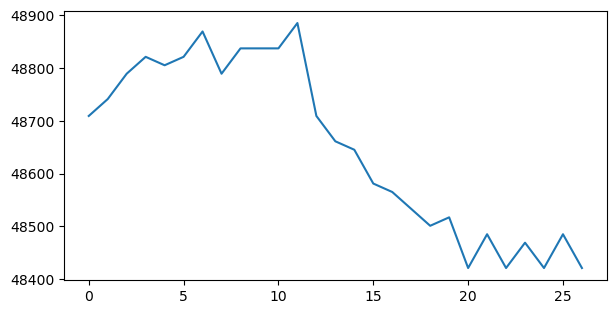

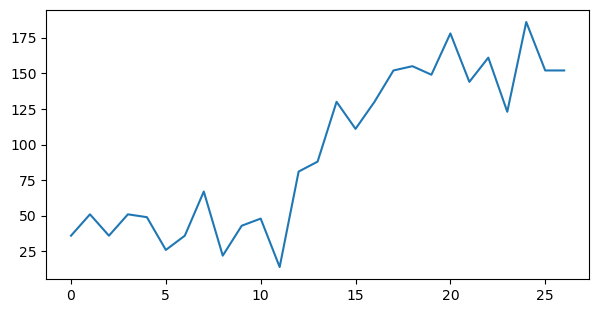

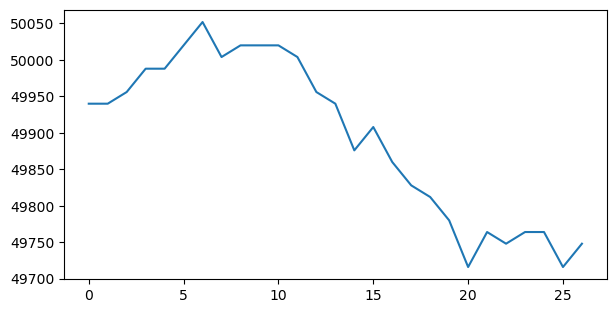

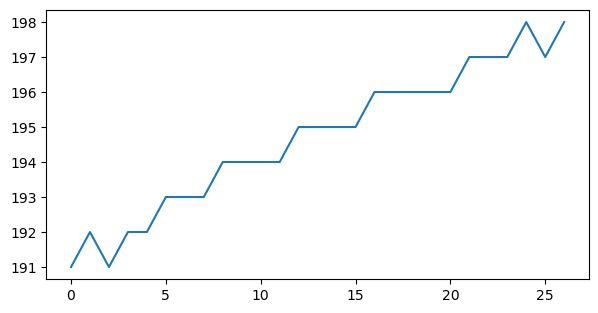

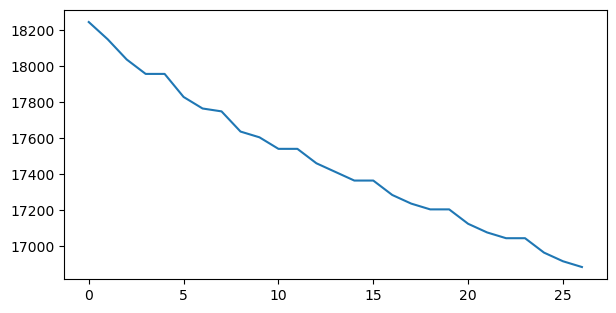

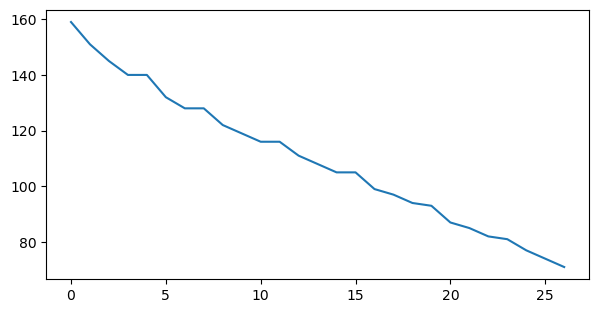

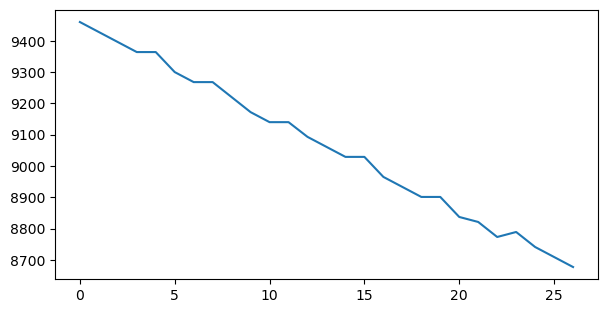

In [9]:
plt.figure()
plt.plot(frames[-2][:, 15:17].view('uint16').byteswap())
plt.figure()
plt.plot(frames[-3][:, 17].view('int8'))
plt.figure()
plt.plot(frames[-2][:, 18:20].view('uint16').byteswap())
plt.figure()
plt.plot(frames[-3][:, 20])
plt.figure()
plt.plot(frames[-2][:, 21:23].view('uint16').byteswap())
plt.figure()
plt.plot(frames[-2][:, 23])
plt.figure()
plt.plot(frames[-2][:, 24:26].view('uint16').byteswap())
plt.figure()
plt.plot(frames[-2][:, 26])
plt.figure()
plt.plot(frames[-2][:, 27:29].view('uint16').byteswap())
plt.figure()
plt.plot(frames[-2][:, 29])
plt.figure()
plt.plot(frames[-2][:, 30:32].view('uint16').byteswap())

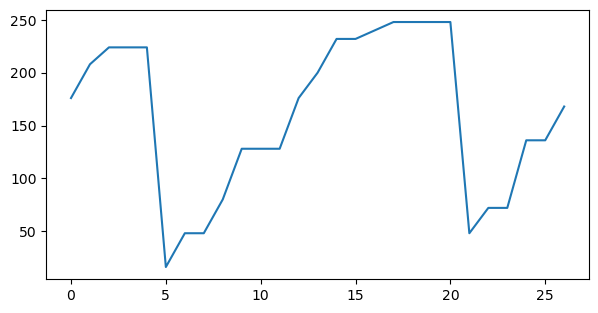

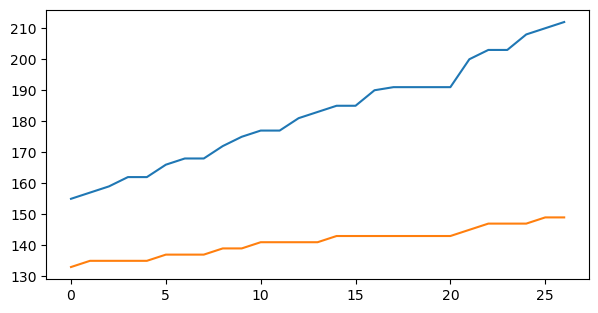

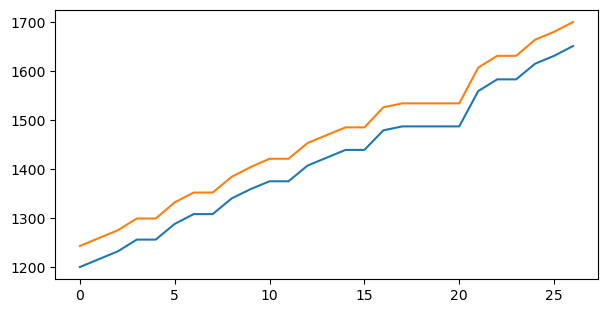

In [10]:
plt.plot(frames[-2][:, 55])
plt.figure()
plt.plot(frames[-2][:, 56:58])
plt.figure()
plt.plot(frames[-2][:, 59:63].view('uint16').byteswap())